# Introduction

This notebook demonstrates how to use Haiku topic modeling framework for NMF topic modeling task. There are three steps described in the following implementations. 
1. preprocess raw documents using Haiku, and build a dataset containing necessary preprocessed data (i.e. text with stopword, without stopword, lemmatized text, tfidf, etc.) for later use.
2. run NMF algorithm with simple parameters, and choose the best # of topics from optimization process.
3. use NMF generated model for topic prediction and query of similar documents from the original corpus.
4. run topic trending over time with NMF model.

The process will generate pickled models (tfidf, w2v, NMF model), topic clouds, topic/keyword/doc matrix tables, and other visualized image files for post analysis.

#### supress warning messages

In [27]:
# -*- coding: utf-8 -*-
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [28]:
import os
import pandas as pd
import numpy as np
import pickle

# plotting
import webbrowser as wb
import pyLDAvis
import matplotlib
import matplotlib.pyplot as plt

# sklearn
from pprint import pprint
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim

# haiku
import haiku
from haiku.TextPreprocess import TextPreprocess
from haiku.topic_modeling.common import Dataset, build_dataset
import haiku.topic_modeling.common as tm_common
import haiku.topic_modeling.nmf_sklearn as tm_nmf_sklearn

### Text preprocessing:
1. detect langage, and only store english texts
2. remove punctuation, and unneeded code
3. To be investigated: replace with known correct words

However, removing stop words and lemmatizing texts will be done later, in a common function.

In [16]:
def preprocess_textfile(datadir, text_filename):
    tp = TextPreprocess()
    texts = []
    verbatim = pd.read_csv(os.path.join(datadir, text_filename + '.csv'), encoding = "ISO-8859-1")
    # generating following files for validation / debugging purpose
    output1 = os.path.join(datadir, text_filename + '_en1.csv')
    output2 = os.path.join(datadir, text_filename + '_en2.csv')
    output3 = os.path.join(datadir, text_filename + '_en3.csv')
    with open(output1, 'w', encoding='utf-16') as fw1, open(output2, 'w', encoding='utf-16') as fw2, open(output3, 'w', encoding='utf-16') as fw3:
        # this only applies to ASAT data
        dtime = []
        for i, row in enumerate(verbatim.values):
            if len(row) > 1:
                # assuming targeted text is the last column (or, the first column)
                text = row[len(row) - 1]
            else:
                text = row[0]
                
            lang = tp.detect_language(text)
            if lang == 'en':
                # convert to lower case and trim start/end
                text = text.strip().lower()

                fw1.write(text + '\n')
                if len(row) > 1:
                    dtime.append(row[0])

                text = tp.remove_punctuation(text)
                fw2.write(text + '\n')

                text = tp.replace_phrases(text)
                # supposed to cover this: text = text.replace('#N#', ' ')
                word_count = len(text.split())
                fw3.write(str(word_count) + '\t' + text + '\n')
                                            
                texts.append(text)
    return texts, dtime

### preprocess raw text

In [29]:
dataset_name = 'asat_verbatim_dtm'

# in notebook you have to use '__file__', instead of __file__
exepath = os.path.dirname(os.path.realpath('__file__'))
data_dir = os.path.join(exepath, 'data')

clean_texts_with_stopwords, dtime = preprocess_textfile(data_dir, dataset_name)
text_filename = os.path.join(data_dir, dataset_name + '_en1.csv')
raw_documents = []
with open(text_filename ,"r", encoding="utf-16") as fin:
    for line in fin.readlines():
        # convert to lowercase
        raw_documents.append(line.strip().lower())
print("Read %d raw text documents" % len(raw_documents))

Read 521 raw text documents


### initializing parameters

In [18]:
least_term_frequency = 20;

In [30]:
'''
define your own Vectorizer for feature extractions
'''
vec_model = TfidfVectorizer(analyzer='word',       
                                    min_df=least_term_frequency,                    # minimum reqd occurences of a word 
                                    stop_words="english",             # remove stop words, optional as it is supposed to be removed already
                                    lowercase=True,                   # convert all words to lowercase
                                    token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                                    # max_features=50000,             # max number of uniq words
                                    )

### Build data
In this function it will do removing stopwords, lemmatizing words, and create all necessary data sets for further processing or analysis

#### build_dataset function parameters:
    clean_texts_with_stopwords - from raw text, detected non-english documents are filtered out. In the English documents, punctuations and other speical text are removed.
    raw_documents - English documents closest to raw data
    data_dir - specified folder to store all output data
    dataset_name - specified output folder name
    vec_model - custom vectorizer function pointer, i.e. feature extraction functions
    w2v_model - custom word2vec model for coherence measurement, if "None", it uses existing input corpus to build w2v model
    least_term_frequency - minimum frequency of terms to be captured in dictionary
    initial_topics_k - starting number of topics

In [32]:
dataset = build_dataset(clean_texts_with_stopwords, raw_documents, data_dir, dataset_name, vec_model, None, least_term_frequency)

creating custom vectorizer...
Sparsicity:  7.970502070916254 %
Created 521 X 19 TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=20,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='[a-zA-Z0-9]{3,}', tokenizer=None, use_idf=True,
        vocabulary=None)-normalized document-term matrix
Vocabulary has 19 distinct terms
01. search (73.09)
02. result (44.33)
03. vkb (42.33)
04. article (33.93)
05. good (29.99)
06. use (26.33)
07. need (25.67)
08. case (25.26)
09. time (23.85)
10. information (23.50)
11. tool (23.48)
12. access (23.05)
13. work (19.93)
14. slow (18.86)
15. line (18.74)
16. make (17.50)
17. issue (16.14)
18. content (15.20)
19. relevant (14.70)
Model has 77 terms


### define custom parameters

In [33]:
if dtime != []:
    dataset.dtime = dtime

In [35]:
dataset.config = tm_common.Config()
dataset.config.kmin = 6
dataset.config.kmax = 10
dataset.config.kstep = 1

# experimenting with more paramters:
#  { 'init' : 'nndsvd', 'solver' : 'mu', 'beta_loss' : 'frobnius', 'max_iter' : 200, 'l1_ratio' : 0, 'alpha' : 0 }
# solver 'cd' does not handle beta_loss = 'kullback-leibler'
# beta_loss = 'kullback-leibler'. default beta_loss = 'frobenius'
# and other parameters specific to the topic modeling API

#Ensure this line has been declared: from sklearn.decomposition import NMF
# example(1)
dataset.myfunc = NMF(init = 'nndsvd', n_components = 10, solver = 'mu', beta_loss = 'kullback-leibler')
dataset.myfunc_optimization = lambda k: NMF(init = 'nndsvd', n_components = k, solver = 'mu', beta_loss = 'kullback-leibler')

# example(2)
#dataset.myfunc = lambda: NMF(init = None, n_components = 10, solver = 'cd', beta_loss='frobenius')
#dataset.myfunc_optimization = lambda k: NMF(init = None, n_components = k, solver = 'cd', beta_loss='frobenius')

Using NMF with sklearn......
Optimizing NMF model with topics #...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
K=06: 
Coherence(w2v)=0.3626

Coherence Score(u_mass):  -4.168358113110954

Coherence Score(c_v):  0.28632459820449757

Coherence Score(c_uci):  -2.5416136900304562


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 521 samples in 0.001s...
[t-SNE] Computed neighbors for 521 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 521 / 521
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.976887
[t-SNE] Error after 1000 iterations: 0.171847
0 -17.614566802978516 21.378843307495117 ['search result case relevant content make slow information time need']
1 7.894076824188232 2.5148098468780518 ['vkb information make tool access good work time content need']
2 -12.348539352416992 -27.41077995300293 ['good result work make article case content information issue line']
3 16.89904022216797 -6.087682247161865 ['use need time tool access case issue line work information']
4 -20.501605987548828 4.540907382965088 ['slow article issue search work line case content good information']
5 10.099169731140137 10.118016242980957 ['article work line content relevant access time result make sea

 'issue']
250  :  always irrelevant solution  negative marks      compared to the old vkb 

Topic #3: ['good' 'result' 'access' 'use' 'tool' 'time' 'slow' 'search' 'relevant'
 'need']
384  :  good job

Topic #4: ['use' 'need' 'time' 'tool' 'access' 'case' 'issue' 'line' 'work'
 'information']
385  :  i have used this 5 times   never helped

Topic #5: ['slow' 'article' 'issue' 'search' 'access' 'use' 'tool' 'time' 'result'
 'relevant']
467  :  very slow

Topic #6: ['article' 'work' 'line' 'content' 'relevant' 'access' 'time' 'result'
 'make' 'issue']
346  :  theres no message or notification if the article have been updated 


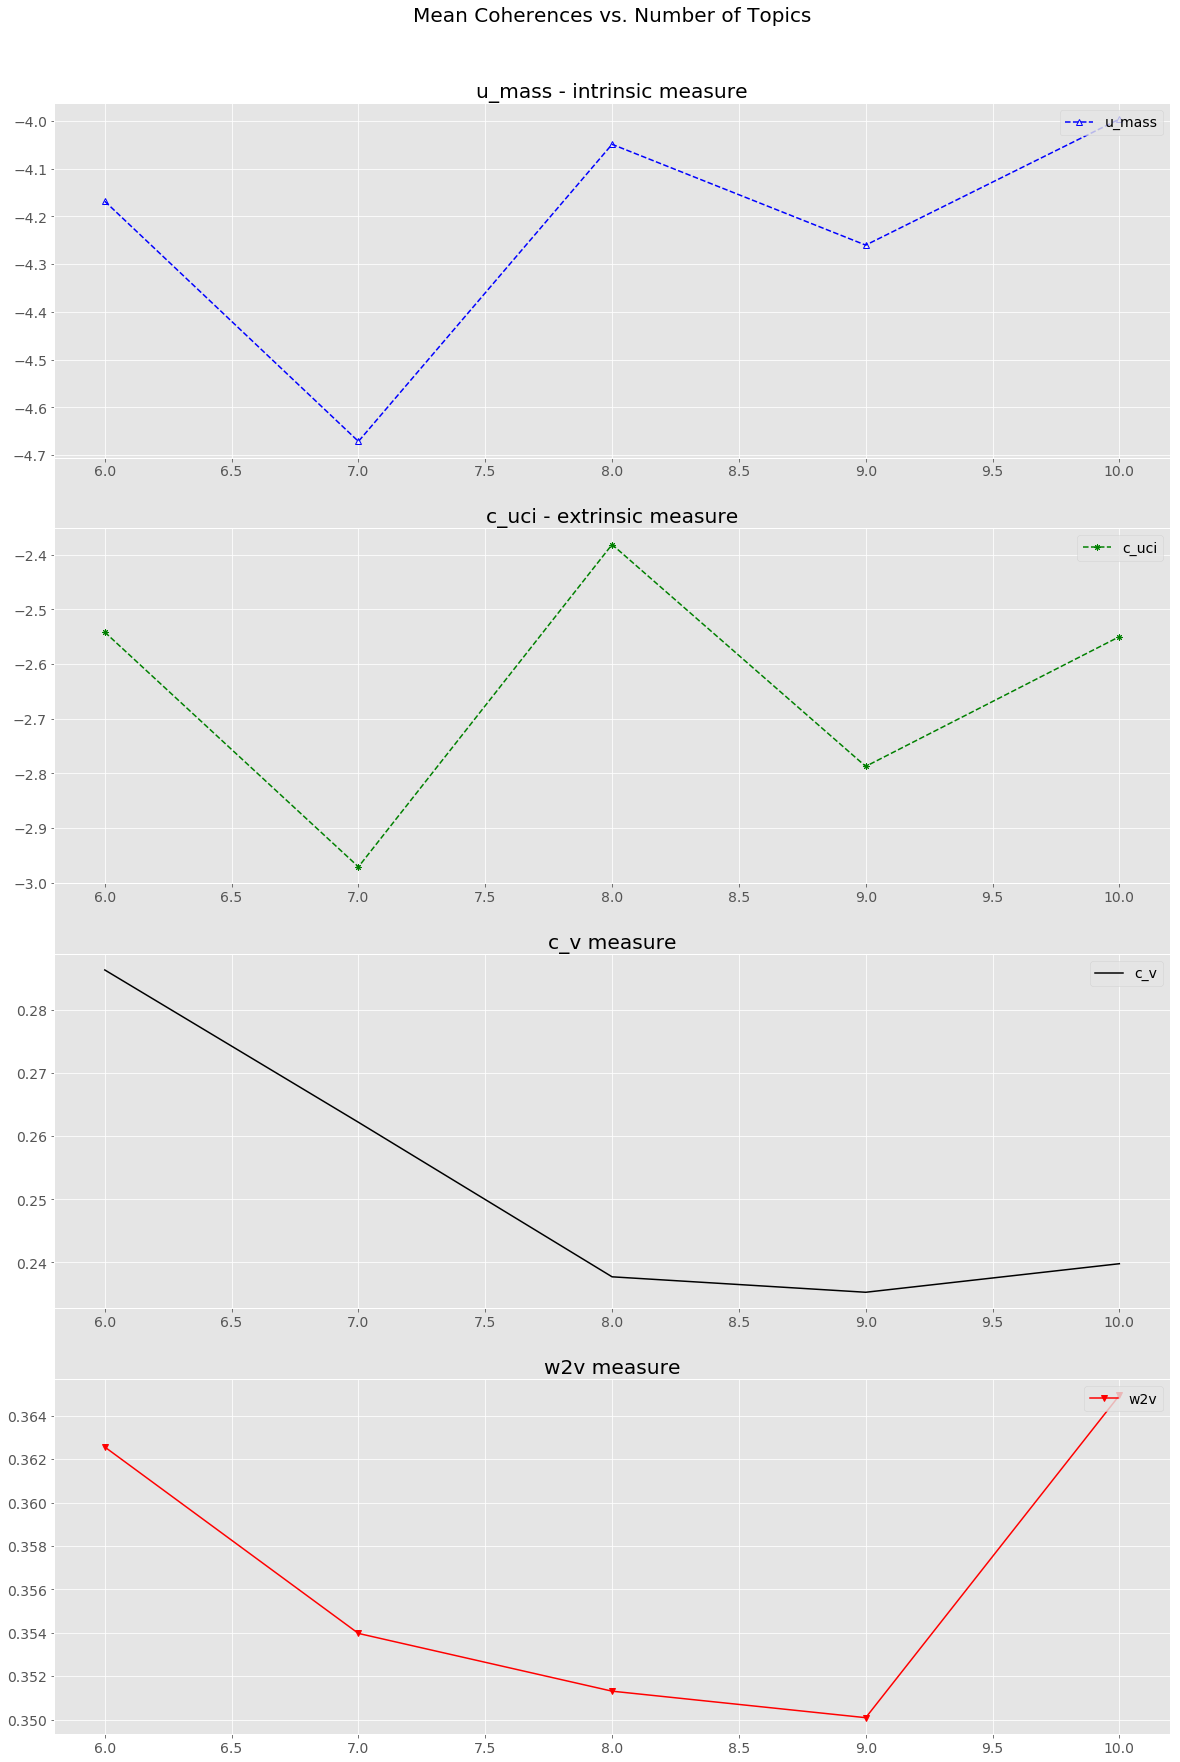

In [36]:
model = tm_nmf_sklearn.create_model(dataset, True)

### Run topics over time model 

compare the DTM results among three models (NMF, LDA sklearn, and LDA gensim)


Topic #1: ['search' 'result' 'content' 'relevant' 'make' 'vkb' 'access' 'use' 'tool'
 'time']
338  :  search is complex  and ranking iin search results make all the difference  thats the difference between google and bing

Topic #2: ['vkb' 'make' 'content' 'access' 'use' 'tool' 'time' 'slow' 'search'
 'result']
39  :  make the vkbs available through asd instead 

Topic #3: ['good' 'result' 'access' 'use' 'tool' 'time' 'slow' 'search' 'relevant'
 'need']
200  :  best stuff ever

Topic #4: ['need' 'line' 'time' 'information' 'tool' 'access' 'work' 'relevant'
 'issue' 'content']
488  :  it takes time to ramp up on this new tool but so far i found it difficult to find the information i want/need 

Topic #5: ['article' 'good' 'access' 'use' 'tool' 'time' 'slow' 'search' 'result'
 'relevant']
346  :  theres no message or notification if the article have been updated 

Topic #6: ['work' 'content' 'article' 'relevant' 'line' 'use' 'tool' 'time' 'slow'
 'search']
149  :  content and indexing i

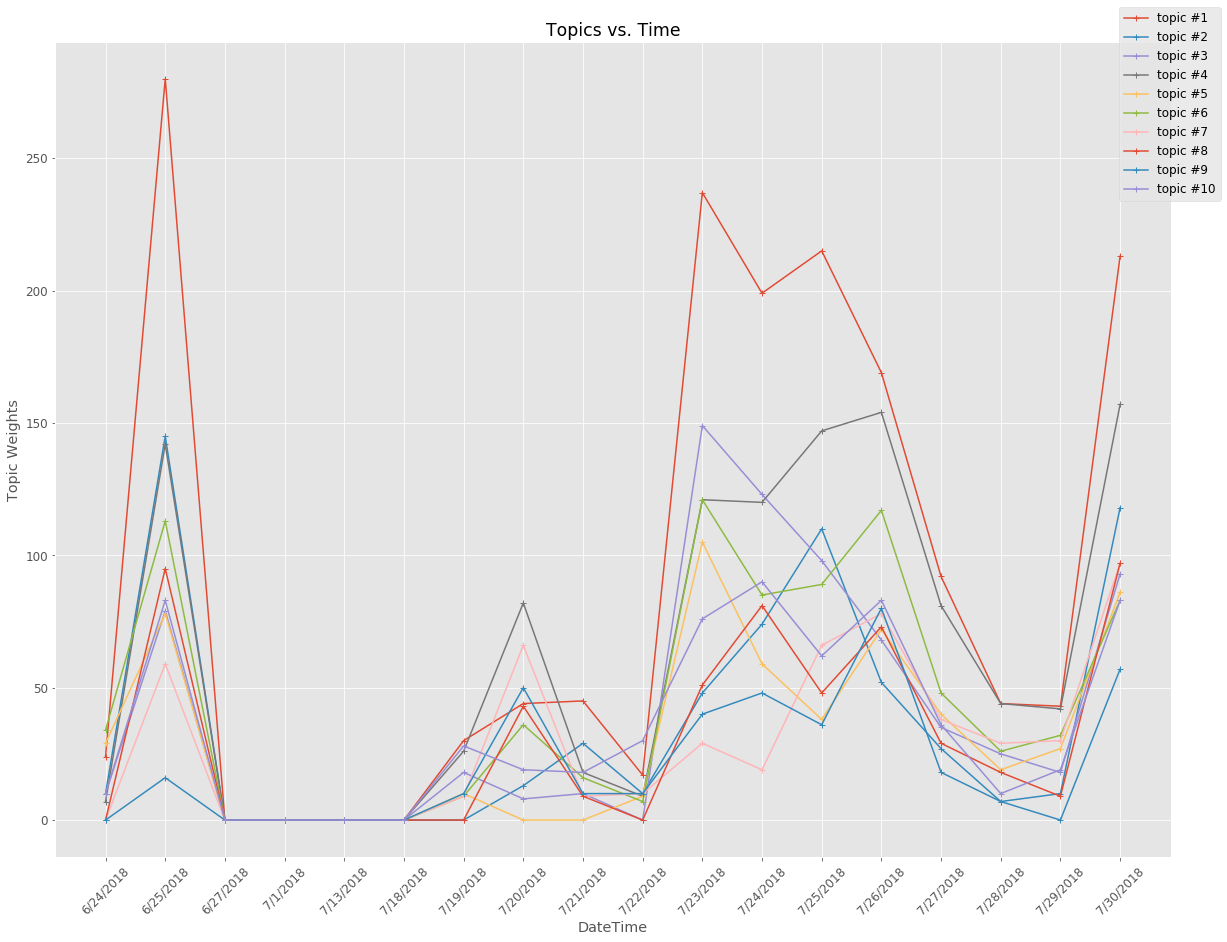

In [38]:
if dataset.dtime != None:
    dataset.topics_k = 5  
    tm_nmf_sklearn.review_dtm(dataset)

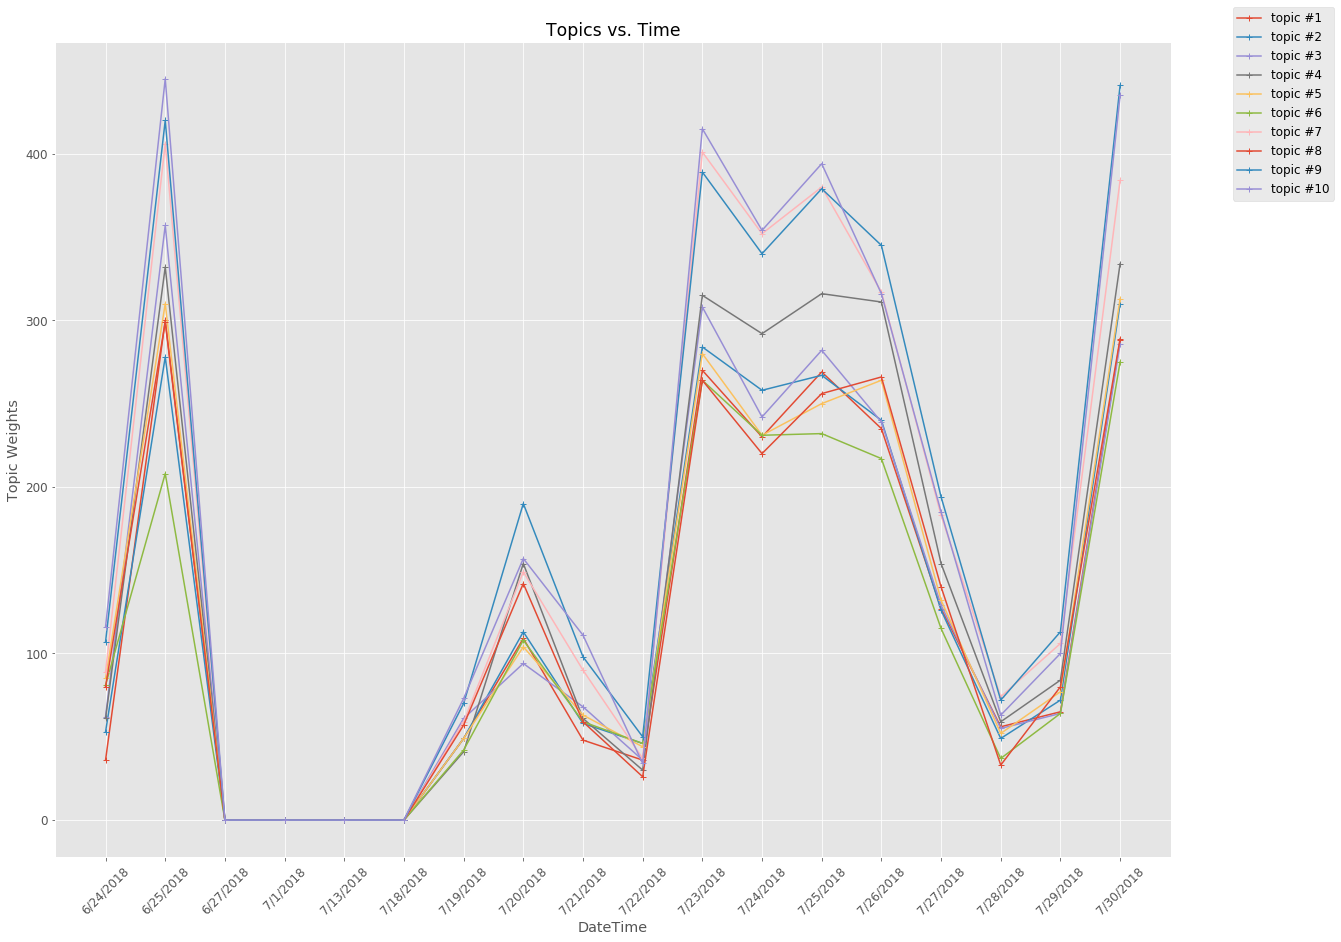

In [25]:
import haiku.topic_modeling.lda_sklearn as tm_lda_sklearn

if dataset.dtime != None:
    dataset.topics_k = 10  
    tm_lda_sklearn.review_dtm(dataset)

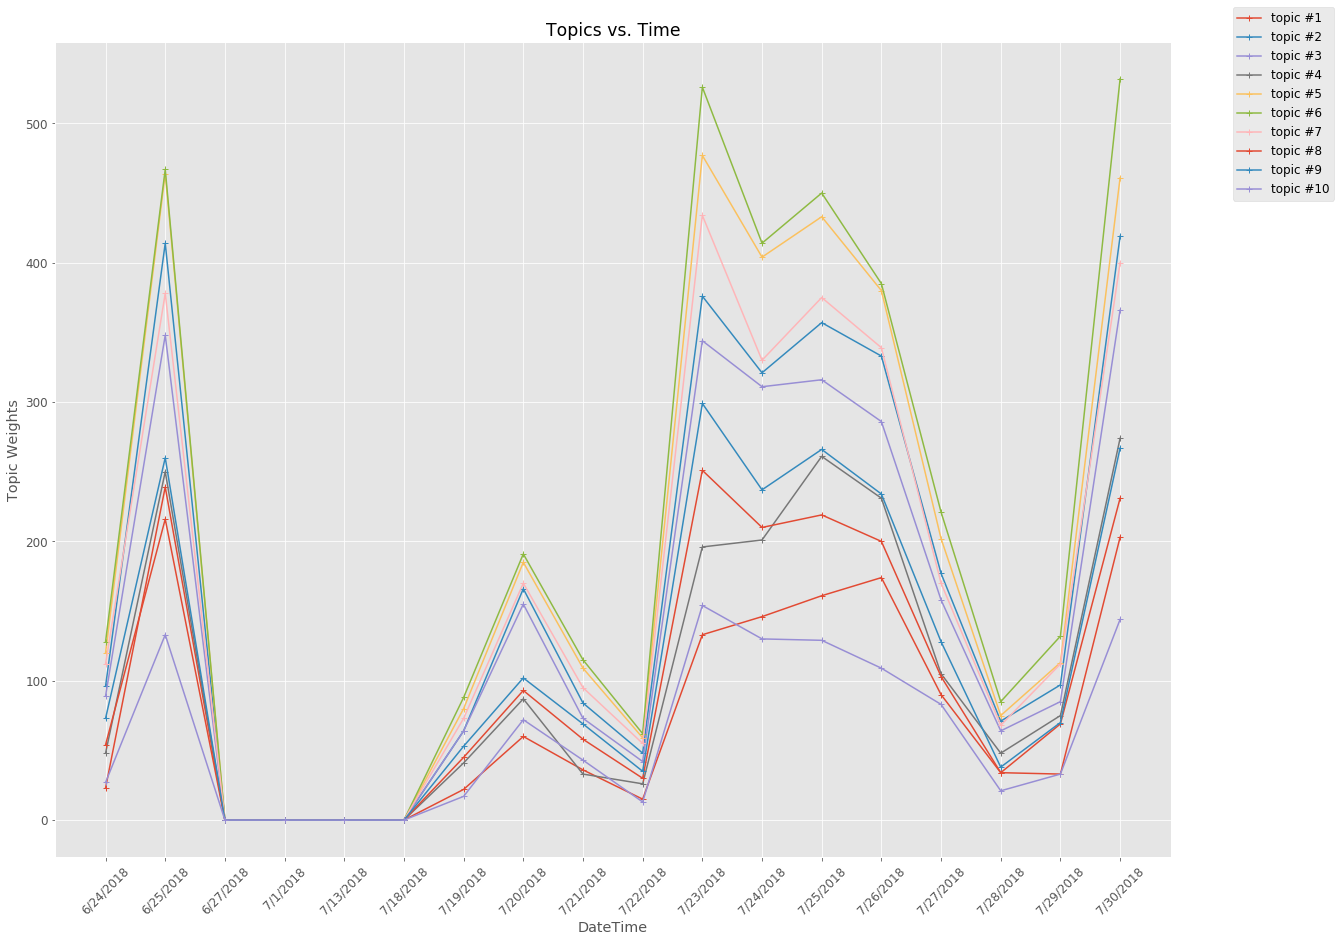

In [26]:
import haiku.topic_modeling.lda_gensim as tm_lda_gensim

if dataset.dtime != None:
    dataset.topics_k = 10  
    tm_lda_gensim.review_dtm(dataset)